# Term Paper (Term-6)

The aim of this research paper is to understand yield curve modelling based on a factor model. Based on model fitting, I want to develop a trading strategy and backtest it on the US Yield Curve.

## The agenda will be:

1. Understand the Nelson-Siegel-Svensson Model and its derivation.
2. Run model fitting on the US yield curves.
3. Find undervalued/overvalued securities and build appropriate trades
4. Build a backtester after chosing appropriate securities: Rates Notional/bonds/Swaps
5. Report Findings



### Referances

https://medium.com/@polanitzer/nelson-siegel-svensson-in-python-estimating-the-spot-rate-curve-using-the-nelson-siegel-svensson-4753969e61c8

# Nelson-Siegel-Svensson Model for Yield Curve Modelling

## Overview

The Nelson-Siegel-Svensson (NSS) model is an extension of the Nelson-Siegel (NS) model, both of which are used for modeling and interpreting the shape of the yield curve in finance. The yield curve represents the relationship between the interest rates (or yields) of debt securities and their time to maturity.

## Nelson-Siegel Model

The Nelson-Siegel model, developed by Charles Nelson and Andrew Siegel in 1987, is a parametric approach that uses a specific functional form to fit the yield curve. It is expressed by the following equation:

$$
Y(t) = \beta_0 + \beta_1 \frac{1-e^{-t/\lambda}}{t/\lambda} + \beta_2 \left[ \frac{1-e^{-t/\lambda}}{t/\lambda} - e^{-t/\lambda} \right]
$$

Where:
- \( Y(t) \) is the yield at time \( t \).
- \( \beta_0, \beta_1, \) and \( \beta_2 \) are parameters representing the level, slope, and curvature of the yield curve, respectively.
- \( \lambda \) is a decay factor determining the speed at which the impact of \( \beta_1 \) and \( \beta_2 \) diminishes.

## Nelson-Siegel-Svensson Extension

The NSS model, proposed by Svensson in 1994, adds an extra term to the Nelson-Siegel equation to better capture variations in the shape of the yield curve, especially at the long end. The extended equation is:

$$
Y(t) = \beta_0 + \beta_1 \frac{1-e^{-t/\lambda_1}}{t/\lambda_1} + \beta_2 \left[ \frac{1-e^{-t/\lambda_1}}{t/\lambda_1} - e^{-t/\lambda_1} \right] + \beta_3 \left[ \frac{1-e^{-t/\lambda_2}}{t/\lambda_2} - e^{-t/\lambda_2} \right]
$$

Where:
- \( \beta_3 \) and \( \lambda_2 \) are additional parameters introduced in the NSS model.
- \( \lambda_2 \) is another decay factor, similar to \( \lambda_1 \), but it primarily affects the tail of the yield curve.

## Decomposition of the Model

### 1. Level (Long-term Rate)

The term \( \beta_0 \) represents the long-term level of the yield curve. It is the asymptotic level that the yield curve approaches as maturity goes to infinity. 

### 2. Slope

The slope of the yield curve is primarily influenced by the term \( \beta_1 \frac{1-e^{-t/\lambda_1}}{t/\lambda_1} \). This term captures the short-end dynamics of the yield curve. The slope is steep when short-term yields are much lower than long-term yields.

### 3. Convexity

The \( \beta_2 \) and \( \beta_3 \) terms add curvature or convexity to the yield curve. The \( \beta_2 \) term, with its exponential decay factor \( \lambda_1 \), adjusts the medium-term segment of the curve. The additional \( \beta_3 \) term in the NSS model, governed by a different decay factor \( \lambda_2 \), allows the model to fit the longer end of the yield curve more accurately. This term is essential for capturing the hump-shaped features of some yield curves.

## Applications

The Nelson-Siegel and Nelson-Siegel-Svensson models are widely used in finance for:
- Yield curve fitting: They provide a smooth curve that fits the observed market yields.
- Interest rate risk management: Understanding the yield curve dynamics helps in managing the interest rate risk in bond portfolios.
- Economic forecasting: The yield curve is an important indicator in economic forecasting.



### Dependency Imports

In [2]:
import pandas as pd
import datetime as dt
import numpy as np
from scipy.optimize import fmin
from tqdm import tqdm

import matplotlib.markers as mk
import matplotlib.ticker as mtick

import matplotlib.pyplot as plt
# plt.style.use('seaborn-notebook')
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context("talk")

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Importing Yield Curve Data

In [2]:
def get_data():
    all_data = []
    for i in range(10,23):
        year = str(2000+i)
        url1 = 'https://home.treasury.gov/resource-center/data-chart-center/interest-rates/daily-treasury-rates.csv/'+year+'/all?type=daily_treasury_yield_curve&field_tdr_date_value='+year+'page&_format=csv'
        data = pd.read_csv(url1)
        all_data.append(data)

    pd_alldata = pd.concat(all_data,ignore_index=True)
    pd_alldata['Date'] = pd.to_datetime(pd_alldata['Date'])
    pd_alldata.index = pd_alldata['Date']

    req_cols = ['1 Mo', '2 Mo', '3 Mo', '4 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr','10 Yr', '20 Yr', '30 Yr']
    final = pd_alldata[req_cols]

    return final

In [3]:
historical_yields = get_data()

In [4]:
historical_yields.head()

,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,,,,
2010-12-31,0.07,NaN,0.12,NaN,0.19,0.29,0.61,1.02,2.01,2.71,3.30,4.13,4.34
2010-12-30,0.05,NaN,0.12,NaN,0.20,0.29,0.66,1.07,2.06,2.76,3.38,4.21,4.43
2010-12-29,0.05,NaN,0.13,NaN,0.20,0.30,0.64,1.05,2.03,2.75,3.35,4.19,4.41
2010-12-28,0.08,NaN,0.15,NaN,0.21,0.31,0.75,1.17,2.18,2.89,3.50,4.33,4.53
2010-12-27,0.06,NaN,0.17,NaN,0.22,0.32,0.71,1.11,2.08,2.76,3.36,4.20,4.42


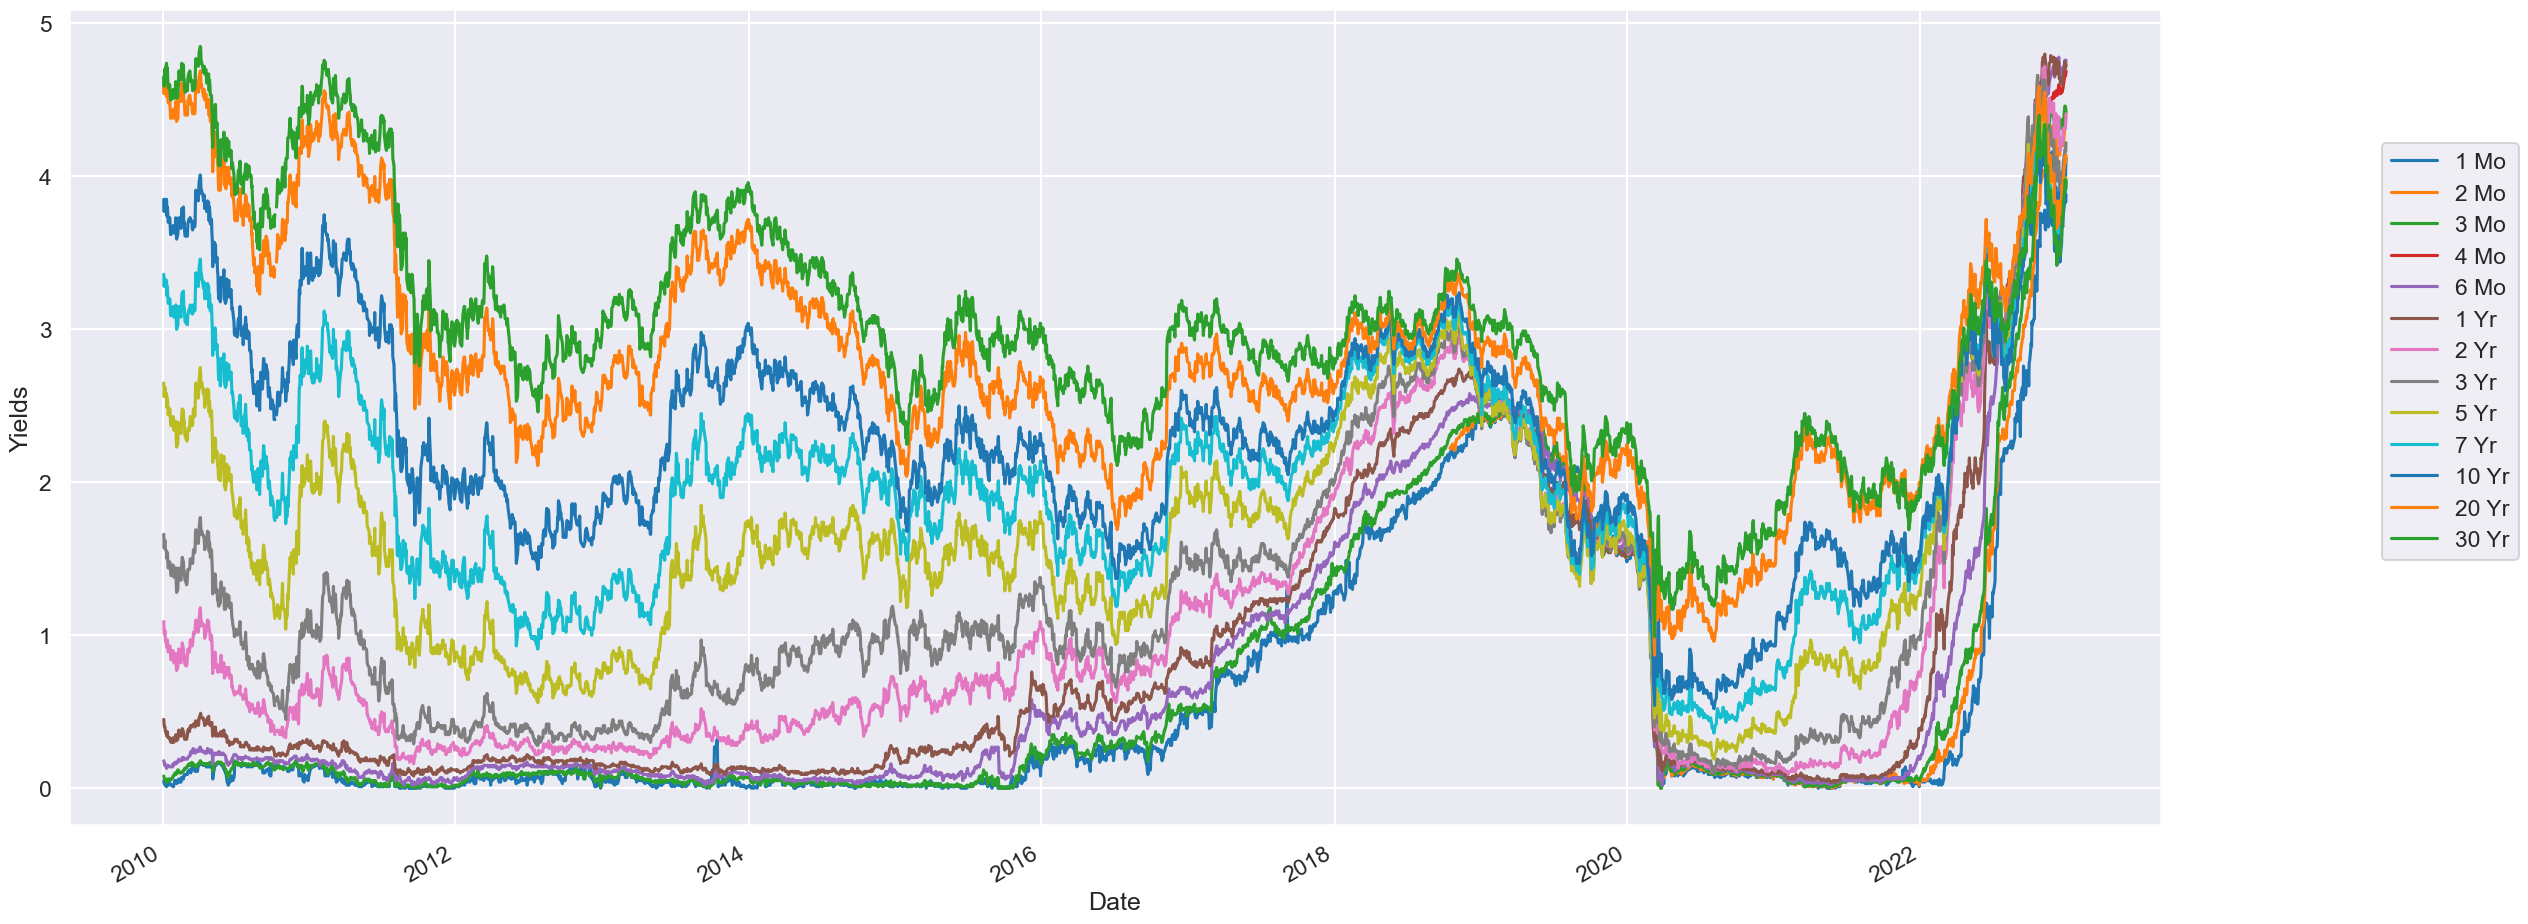

In [5]:
historical_yields.plot(figsize=(27,12))
plt.ylabel("Yields")
plt.legend(bbox_to_anchor=(1.1, 0.85), loc=2)
plt.show()

In [6]:
def get_fit_df(date, historical_yields):
    yield_fit_df = pd.DataFrame()
    yield_fit_df["Maturity"] = [1/12,2/12,3/12,4/12,6/12,1,2,3,5,7,10,20,30]
    yield_fit_df["Yield"] = historical_yields.loc[date].values/100
    return yield_fit_df


In [7]:
df = get_fit_df("2013-01-02", historical_yields)

In [8]:
def plot_yields(sf):
    sf = sf.dropna()
    sf1 = sf.copy()
    
    # If Yield is a decimal representing a percentage, convert to basis points
    sf1['Y'] = round(sf1['Yield']*100, 4)
    
    # Ensure the formatting is correct for the Maturity column if needed
    sf = sf.style.format({'Maturity': '{:,.2f}'.format, 'Yield': '{:,.4%}'})
    
    # Create a figure with appropriate size to avoid overlapping labels
    fig, ax = plt.subplots(figsize=(13, 7))
    plt.title("Nelson-Siegel-Svensson Model - Unfitted Yield Curve")
    ax.set_facecolor("black")
    fig.patch.set_facecolor('white')
    
    X = sf1["Maturity"]
    Y = sf1["Y"]
    
    plt.scatter(X, Y, marker="o", c="blue")
    plt.xlabel('Maturity')
    plt.ylabel('Yield')
    
    # Remove the legend if it's not necessary
    # ax.legend(loc="lower right", title="Yield")
    
    plt.grid(True)
    plt.show()

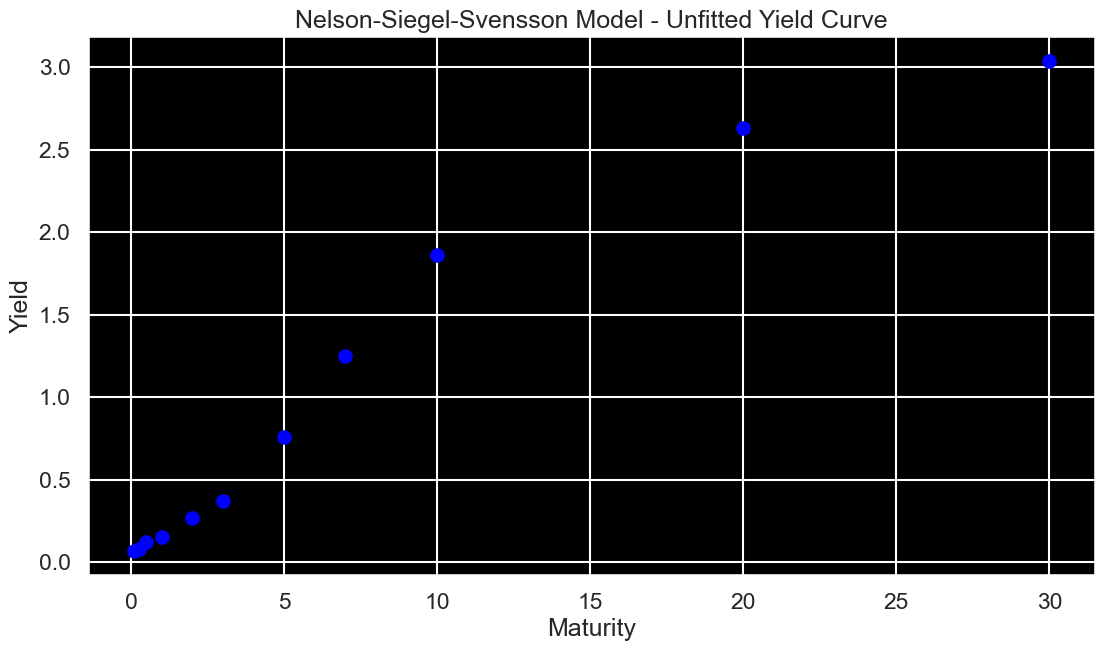

In [9]:
plot_yields(df)

In [10]:
# Fit Initial Parameters
β0 = 0.01
β1 = 0.01
β2 = 0.01
β3 = 0.01
λ0 = 1.00
λ1 = 1.00

In [11]:
df['NSS'] = (β0)+(β1*((1-np.exp(-df['Maturity']/λ0))/(df['Maturity']/λ0)))+(β2*((((1-np.exp(-df['Maturity']/λ0))/(df['Maturity']/λ0)))-(np.exp(-df['Maturity']/λ0))))+(β3*((((1-np.exp(-df['Maturity']/λ1))/(df['Maturity']/λ1)))-(np.exp(-df['Maturity']/λ1))))

In [12]:
def plot_unfitted_yield_curve(df):
    
    df['Y'] = round(df['Yield'] * 100, 2)
    
    # It seems you are trying to calculate a fitted yield curve, ensure that β0, β1, β2, β3, λ0, and λ1 are defined before this line
    df['NSS'] = (β0) + (β1 * ((1 - np.exp(-df['Maturity'] / λ0)) / (df['Maturity'] / λ0))) + \
                (β2 * ((((1 - np.exp(-df['Maturity'] / λ0)) / (df['Maturity'] / λ0)) - np.exp(-df['Maturity'] / λ0)))) + \
                (β3 * ((((1 - np.exp(-df['Maturity'] / λ1)) / (df['Maturity'] / λ1)) - np.exp(-df['Maturity'] / λ1))))

    df['N'] = round(df['NSS'] * 100, 2)
    
    fontsize = 15
    fig, ax = plt.subplots(figsize=(13, 7))
    plt.title("Nelson-Siegel-Svensson Model - Unfitted Yield Curve", fontsize=fontsize)
    ax.set_facecolor("black")
    fig.patch.set_facecolor('white')

    X = df["Maturity"]
    Y = df["Y"]
    x = df["Maturity"]
    y = df["N"]

    ax.plot(x, y, color="orange", label="NSS")
    plt.scatter(x, y, marker="o", c="orange")
    plt.scatter(X, Y, marker="o", c="blue")
    
    plt.xlabel('Maturity', fontsize=fontsize)
    plt.ylabel('Yield in Bps', fontsize=fontsize)
    
    # Set ticks for x and y axes
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Remove PercentFormatter if using basis points
    # ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    ax.legend(loc="lower right", title="Yield")
    plt.grid(True)
    plt.show()

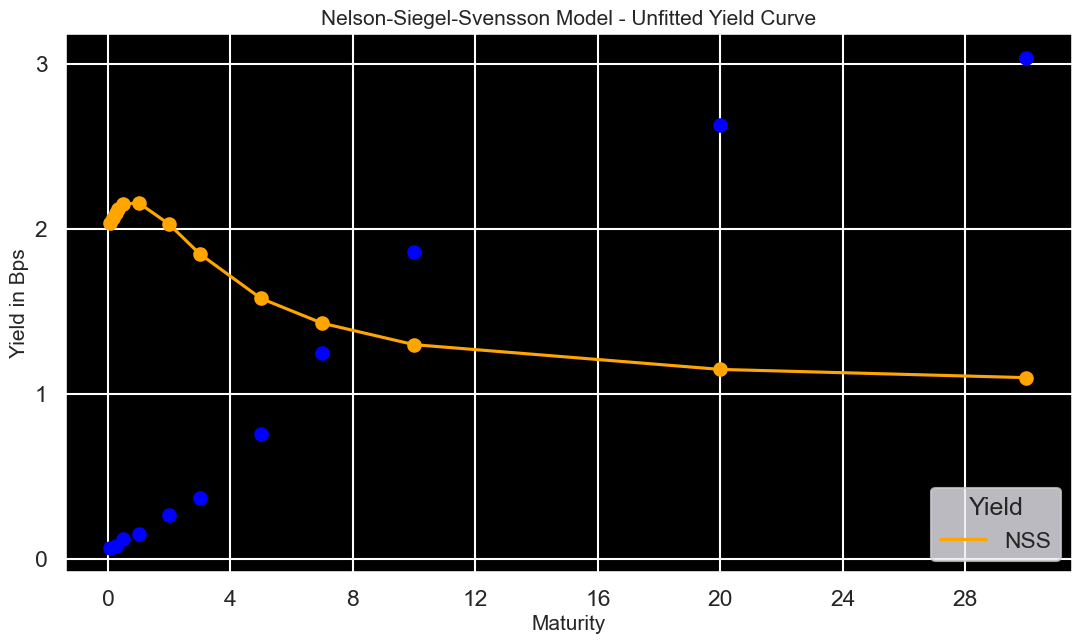

In [13]:

plot_unfitted_yield_curve(df)

In [14]:
df['Residual'] =  (df['Yield'] - df['NSS'])**2
df22 = df[['Maturity','Yield','NSS','Residual']]  
df22.style.format({'Maturity': '{:,.0f}'.format,'Yield': '{:,.2%}','NSS': '{:,.2%}','Residual': '{:,.9f}'})

,Maturity,Yield,NSS,Residual
0,0,0.07%,2.04%,0.000387425
1,0,nan%,2.07%,nan
2,0,0.08%,2.10%,0.000406744
3,0,nan%,2.12%,nan
4,0,0.12%,2.15%,0.000411179
5,1,0.15%,2.16%,0.000404252
6,2,0.27%,2.03%,0.000308468
7,3,0.37%,1.85%,0.000219229
8,5,0.76%,1.58%,0.000067648
9,7,1.25%,1.43%,0.000003110


In [15]:
np.sum(df['Residual'])

0.0028348272232285483

In [16]:
def myval(c):
    df['NSS'] =(c[0])+(c[1]*((1-np.exp(-df['Maturity']/c[4]))/(df['Maturity']/c[4])))+(c[2]*((((1-np.exp(-df['Maturity']/c[4]))/(df['Maturity']/c[4])))-(np.exp(-df['Maturity']/c[4]))))+(c[3]*((((1-np.exp(-df['Maturity']/c[5]))/(df['Maturity']/c[5])))-(np.exp(-df['Maturity']/c[5]))))
    df['Residual'] =  (df['Yield'] - df['NSS'])**2
    val = np.sum(df['Residual'])
    print("[β0, β1, β2, β3, λ0, λ1]=",c,", SUM:", val)
    return(val)
    
c = fmin(myval, [0.01, 0.01, 0.01, 0.01, 1.00, 1.00])

[β0, β1, β2, β3, λ0, λ1]= [0.01 0.01 0.01 0.01 1.   1.  ] , SUM: 0.0028348272232285483
[β0, β1, β2, β3, λ0, λ1]= [0.0105 0.01   0.01   0.01   1.     1.    ] , SUM: 0.0029203688019556672
[β0, β1, β2, β3, λ0, λ1]= [0.01   0.0105 0.01   0.01   1.     1.    ] , SUM: 0.002913216128802925
[β0, β1, β2, β3, λ0, λ1]= [0.01   0.01   0.0105 0.01   1.     1.    ] , SUM: 0.002855849147418865
[β0, β1, β2, β3, λ0, λ1]= [0.01   0.01   0.01   0.0105 1.     1.    ] , SUM: 0.002855849147418865
[β0, β1, β2, β3, λ0, λ1]= [0.01 0.01 0.01 0.01 1.05 1.  ] , SUM: 0.002849889133632351
[β0, β1, β2, β3, λ0, λ1]= [0.01 0.01 0.01 0.01 1.   1.05] , SUM: 0.0028294867532673955
[β0, β1, β2, β3, λ0, λ1]= [0.0095     0.01016667 0.01016667 0.01016667 1.01666667 1.01666667] , SUM: 0.0027966474530347423
[β0, β1, β2, β3, λ0, λ1]= [0.009   0.01025 0.01025 0.01025 1.025   1.025  ] , SUM: 0.0027407082853791453
[β0, β1, β2, β3, λ0, λ1]= [0.00966667 0.00958333 0.01025    0.01025    1.025      1.025     ] , SUM: 0.0027422740265729

In [17]:
# Optimise parameters

df = get_fit_df("2013-01-02", historical_yields)
def get_residual(params):
    df['NSS'] =(params[0])+(params[1]*((1-np.exp(-df['Maturity']/params[4]))/(df['Maturity']/params[4])))+(params[2]*((((1-np.exp(-df['Maturity']/params[4]))/(df['Maturity']/params[4])))-(np.exp(-df['Maturity']/params[4]))))+(params[3]*((((1-np.exp(-df['Maturity']/params[5]))/(df['Maturity']/params[5])))-(np.exp(-df['Maturity']/params[5]))))
    df['Residual'] =  (df['Yield'] - df['NSS'])**2
    val = np.sum(df['Residual'])
    print("[β0, β1, β2, β3, λ0, λ1]=",c,", SUM:", val)
    return(val)
c = fmin(get_residual, [0.01, 0.01, 0.01, 0.01, 1.00, 1.00])


[β0, β1, β2, β3, λ0, λ1]= [ 0.03636112 -0.03601246 -0.07216256  0.02633631  2.021967    1.12458217] , SUM: 0.0028348272232285483
[β0, β1, β2, β3, λ0, λ1]= [ 0.03636112 -0.03601246 -0.07216256  0.02633631  2.021967    1.12458217] , SUM: 0.0029203688019556672
[β0, β1, β2, β3, λ0, λ1]= [ 0.03636112 -0.03601246 -0.07216256  0.02633631  2.021967    1.12458217] , SUM: 0.002913216128802925
[β0, β1, β2, β3, λ0, λ1]= [ 0.03636112 -0.03601246 -0.07216256  0.02633631  2.021967    1.12458217] , SUM: 0.002855849147418865
[β0, β1, β2, β3, λ0, λ1]= [ 0.03636112 -0.03601246 -0.07216256  0.02633631  2.021967    1.12458217] , SUM: 0.002855849147418865
[β0, β1, β2, β3, λ0, λ1]= [ 0.03636112 -0.03601246 -0.07216256  0.02633631  2.021967    1.12458217] , SUM: 0.002849889133632351
[β0, β1, β2, β3, λ0, λ1]= [ 0.03636112 -0.03601246 -0.07216256  0.02633631  2.021967    1.12458217] , SUM: 0.0028294867532673955
[β0, β1, β2, β3, λ0, λ1]= [ 0.03636112 -0.03601246 -0.07216256  0.02633631  2.021967    1.12458217] ,

In [18]:
β0 = c[0]
β1 = c[1]
β2 = c[2]
β3 = c[3]
λ0 = c[4]
λ1 = c[5]
print("[β0, β1, β2, β3, λ0, λ1]=", [c[0].round(2), c[1].round(2), c[2].round(2), c[3].round(2), c[4].round(2), c[5].round(2)])

[β0, β1, β2, β3, λ0, λ1]= [0.04, -0.04, -0.07, 0.03, 2.02, 1.12]


In [19]:
def plot_fitted_yield_curve(df, c):
    [β0, β1, β2, β3, λ0, λ1] = c
    # Calculate the NSS model yield
    df['NSS'] = (β0) + \
                (β1 * ((1 - np.exp(-df['Maturity'] / λ0)) / (df['Maturity'] / λ0))) + \
                (β2 * (((1 - np.exp(-df['Maturity'] / λ0)) / (df['Maturity'] / λ0)) - np.exp(-df['Maturity'] / λ0))) + \
                (β3 * (((1 - np.exp(-df['Maturity'] / λ1)) / (df['Maturity'] / λ1)) - np.exp(-df['Maturity'] / λ1)))
    
    # Convert Yield to basis points if it is in decimal form
    df['Y'] = round(df['Yield'] * 100, 2)
    df['N'] = round(df['NSS'] * 100, 2)
    
    fontsize = 15
    fig, ax = plt.subplots(figsize=(13, 7))
    plt.title("Nelson-Siegel-Svensson Model - Fitted Yield Curve", fontsize=fontsize)
    ax.set_facecolor("black")
    fig.patch.set_facecolor('white')

    X = df["Maturity"]
    Y = df["Y"]
    x = df["Maturity"]
    y = df["N"]
    
    ax.plot(x, y, color="orange", label="NSS")
    plt.scatter(X, Y, marker="o", c="blue", label="Market Yield")
    
    plt.xlabel('Maturity', fontsize=fontsize)
    plt.ylabel('Yield', fontsize=fontsize)
    
    # Adjust the ticks for the axes
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Remove PercentFormatter if using basis points
    # ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    ax.legend(loc="upper left", title="Legend")
    plt.grid(True)
    plt.show()

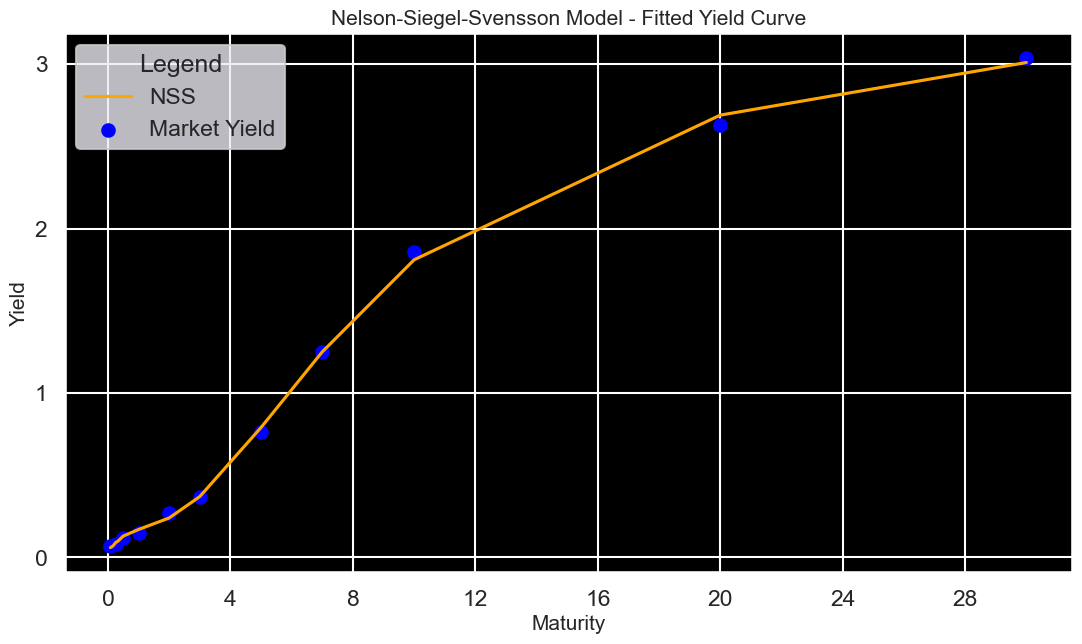

In [20]:
df = get_fit_df("2013-01-02", historical_yields)
plot_fitted_yield_curve(df, c)

## Wrap Code to get Curve parameters for any Given Term Structure 

In [21]:
def get_params(df, print_updates=False):
    def get_residual(params):
        # Calculate the NSS model yield with current params
        df['NSS'] = (params[0]) + \
                    (params[1] * ((1 - np.exp(-df['Maturity'] / params[4])) / (df['Maturity'] / params[4]))) + \
                    (params[2] * (((1 - np.exp(-df['Maturity'] / params[4])) / (df['Maturity'] / params[4])) - np.exp(-df['Maturity'] / params[4]))) + \
                    (params[3] * (((1 - np.exp(-df['Maturity'] / params[5])) / (df['Maturity'] / params[5])) - np.exp(-df['Maturity'] / params[5])))
        # Calculate the sum of squared residuals
        df['Residual'] = (df['Yield'] - df['NSS']) ** 2
        val = np.sum(df['Residual'])
        if print_updates:
            # Use params in the print statement instead of c
            print("[β0, β1, β2, β3, λ0, λ1]=", params, ", SUM:", val)
        return val

    # Use fmin to minimize the residual sum of squares and find the best-fitting parameters
    c = fmin(get_residual, [0.01, 0.01, 0.01, 0.01, 1.00, 1.00])
    return c

In [22]:
historical_yields_og = get_data()

In [32]:
historical_yields = historical_yields_og.copy()

In [ ]:
historical_yields["β0"] = 0
historical_yields["β1"] = 0
historical_yields["β2"] = 0
historical_yields["β3"] = 0
historical_yields["λ0"] = 0
historical_yields["λ1"] = 0

for date in tqdm(historical_yields.index):

    df = get_fit_df(date, historical_yields[['1 Mo', '2 Mo', '3 Mo', '4 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr','7 Yr', '10 Yr', '20 Yr', '30 Yr']])
    c = get_params(df)

    historical_yields.loc[date, 'β0'] = c[0]
    historical_yields.loc[date, 'β1'] = c[1]
    historical_yields.loc[date, 'β2'] = c[2]
    historical_yields.loc[date, 'β3'] = c[3]
    historical_yields.loc[date, 'λ0'] = c[4]
    historical_yields.loc[date, 'λ1'] = c[5]


In [35]:
import pickle
with open('Yield_Features.pkl', 'wb') as file:
    pickle.dump(historical_yields, file)

### Exploratory Analysis of Features

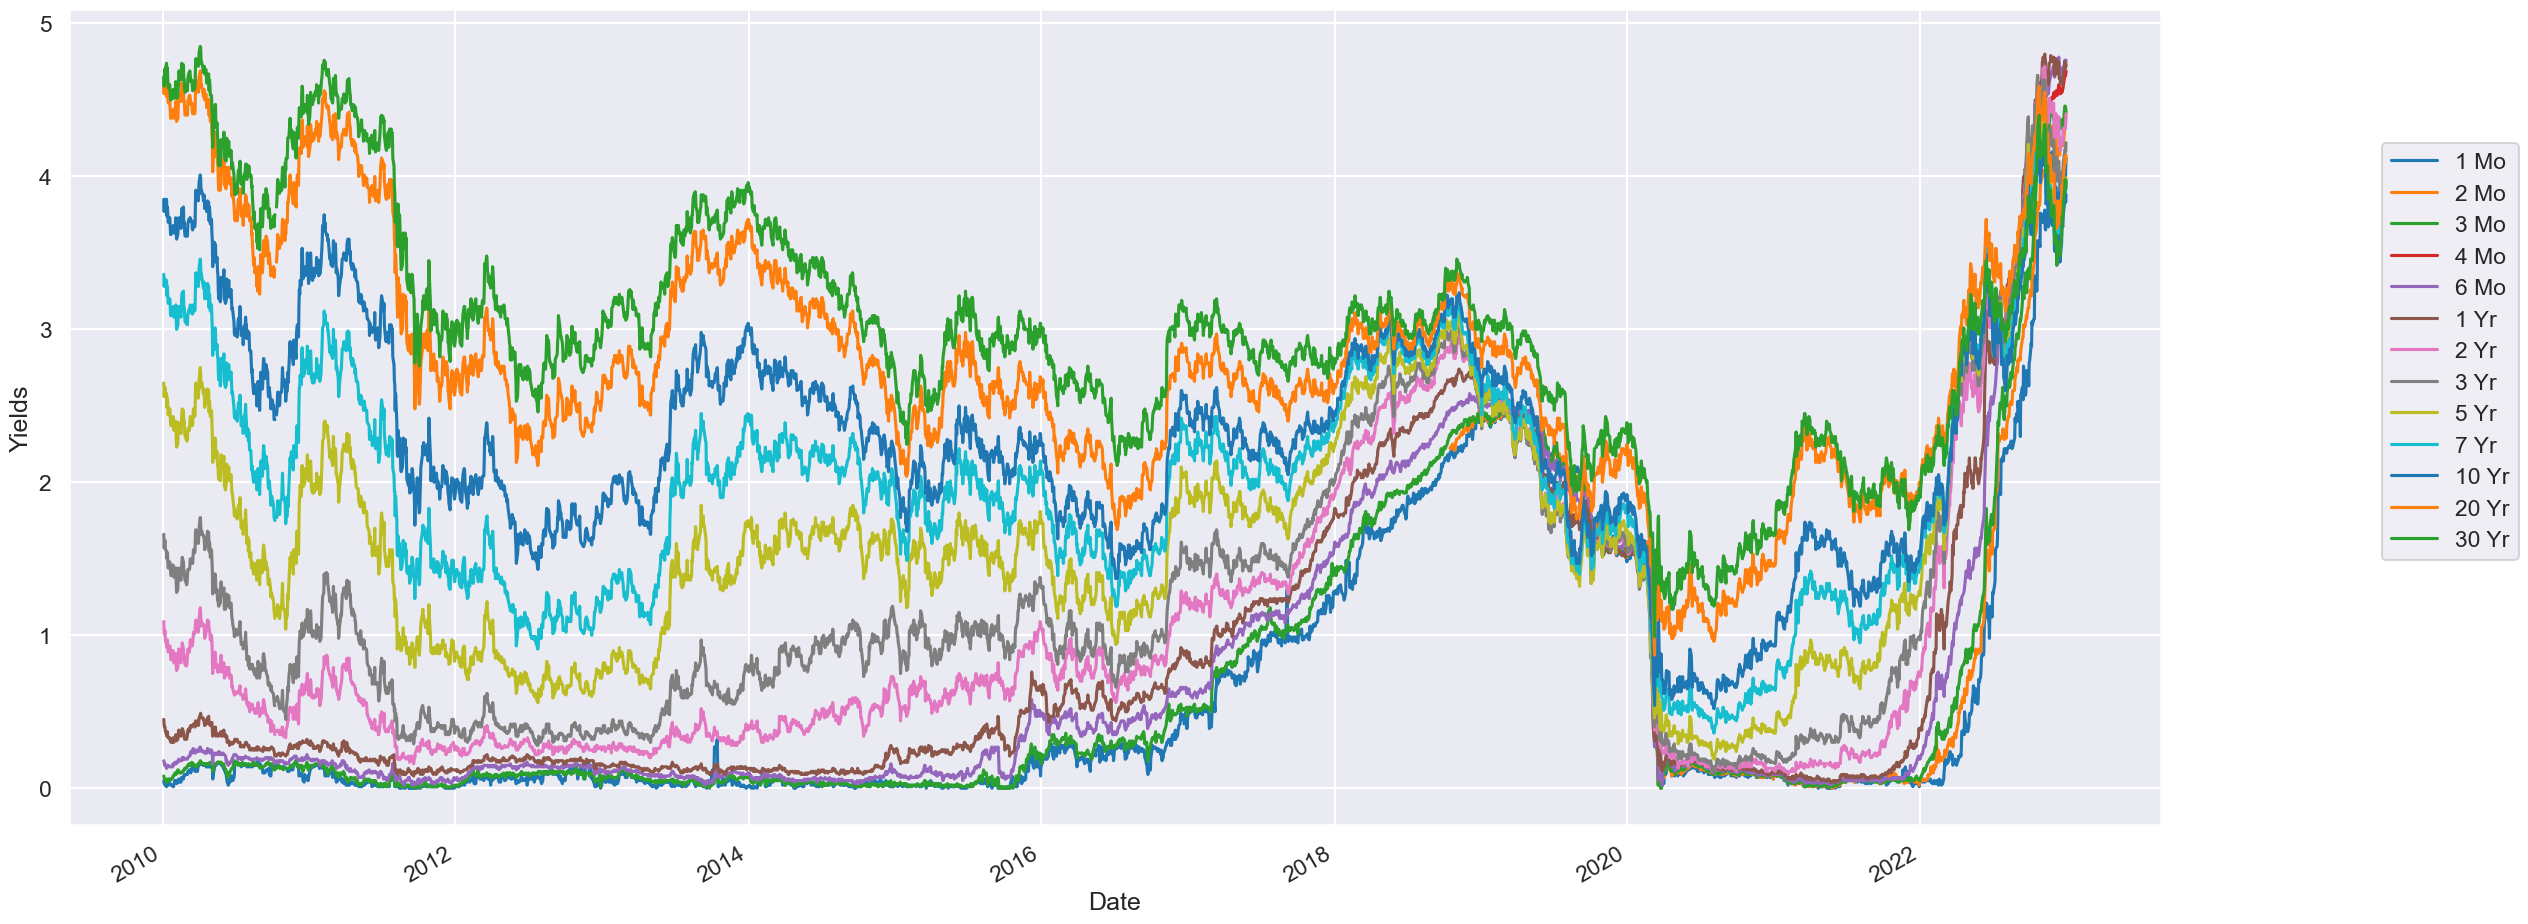

In [37]:
historical_yields[['1 Mo', '2 Mo', '3 Mo', '4 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr','7 Yr', '10 Yr', '20 Yr', '30 Yr']].plot(figsize=(27,12))
plt.ylabel("Yields")
plt.legend(bbox_to_anchor=(1.1, 0.85), loc=2)
plt.show()

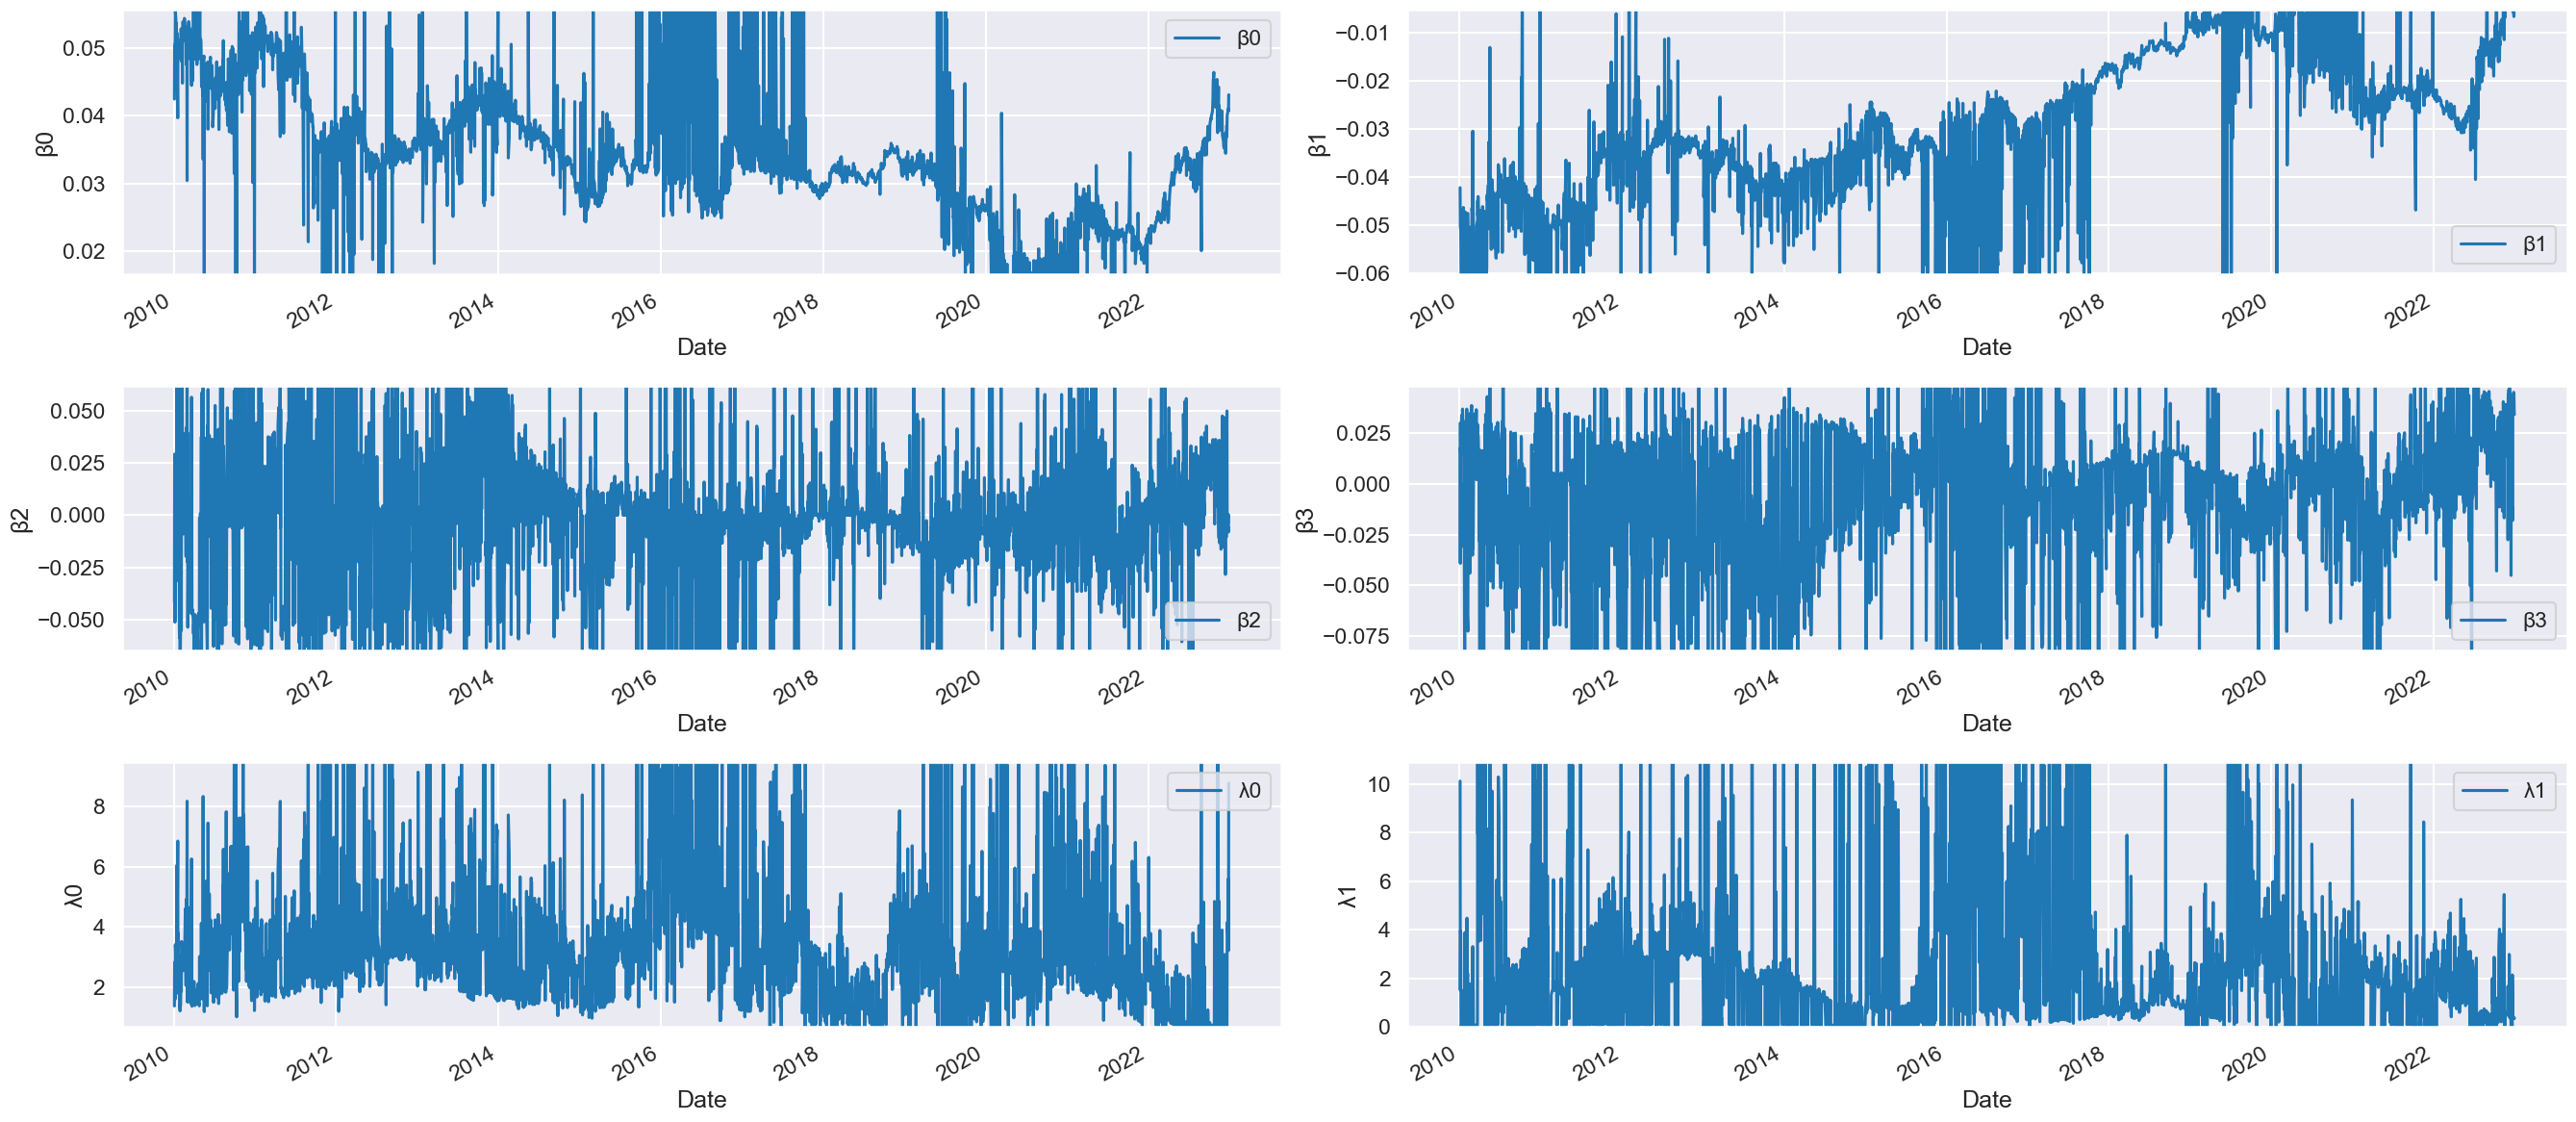

In [58]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(27, 12))

for i, column in enumerate(['β0', 'β1', 'β2', 'β3', 'λ0', 'λ1']):
    ax = axes[i//2, i%2]
    historical_yields[column].plot(ax=ax)
    ax.set_ylabel(column)
    ax.set_ylim(historical_yields[column].quantile(0.05), historical_yields[column].quantile(0.95))  # Adjusting y-limits
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

## Building a Trading Model

In [285]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from matplotlib.colors import LinearSegmentedColormap

In [121]:
import pickle
with open('Yield_Features.pkl', 'rb') as file:
    historical_yields = pickle.load(file)
historical_yields = historical_yields.sort_index(ascending=True)

In [123]:
#Remove 2 and 4 month yields from the trading model - because of nans
historical_yields  = historical_yields.drop(['2 Mo','4 Mo'],axis=1)
historical_yields.dropna(inplace=True)

In [137]:
historical_yields

,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,β0,β1,β2,β3,λ0,λ1
Date,,,,,,,,,,,,,,,,,
2010-01-04,0.05,0.08,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.60,4.65,0.042467,-0.042191,-0.041680,0.029976,1.362918,10.118358
2010-01-05,0.03,0.07,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59,0.050399,-0.050070,0.029333,-0.039048,2.820010,1.511497
2010-01-06,0.03,0.06,0.15,0.40,1.01,1.60,2.60,3.33,3.85,4.63,4.70,0.050710,-0.050736,-0.051342,0.017991,1.659650,3.964430
2010-01-07,0.02,0.05,0.16,0.40,1.03,1.62,2.62,3.33,3.85,4.62,4.69,0.050957,-0.051010,-0.050755,0.014134,1.585154,3.804250
2010-01-08,0.02,0.05,0.15,0.37,0.96,1.56,2.57,3.31,3.83,4.61,4.70,0.055513,-0.059689,0.003314,0.024756,3.405824,-0.000010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,3.80,4.34,4.67,4.66,4.31,4.09,3.86,3.83,3.75,3.99,3.82,0.040081,-0.005496,-0.005792,0.043419,4.145627,0.394744
2022-12-27,3.87,4.46,4.76,4.75,4.32,4.17,3.94,3.93,3.84,4.10,3.93,0.040676,-0.005969,-0.003868,0.045263,3.661024,0.362189
2022-12-28,3.86,4.46,4.75,4.71,4.31,4.18,3.97,3.97,3.88,4.13,3.98,0.041052,-0.006549,0.000343,0.044694,5.592074,0.344528


In the described trading strategy, it's based on the premise that the parameters 'β0', 'β1', 'β2', 'β3', 'λ0', and 'λ1' effectively capture the dynamics of the yield curve, which provides a foundation for trading fixed income products across various maturities. A Logistic Regression model is employed to leverage these six parameters for predicting the day-to-day changes in interest rates.

The approach involves training the model over a specified lookback period, allowing it to learn from historical data. It's noted that the model undergoes recalibration at regular intervals, every specified number of days, to adapt to new market information and maintain its predictive accuracy.

The methodology for dividing the data into training and testing sets follows a walk-forward method, facilitated by a custom function designed to create train-test splits based on specified training and testing sizes. This function ensures that each subsequent training set is immediately followed by a test set, reflecting a continuous and sequential approach to model evaluation.

Profit and Loss (PnL) from the strategy are quantified in basis points (bps), providing a measure of performance in terms closely aligned with fixed income trading metrics. The cumulative PnL is visualized through plotting, showcasing the model's performance over time for a given maturity, based on the recalibration frequency and the length of the lookback period employed in training the model.

In [260]:
def custom_time_series_split(n_samples, train_size, test_size):
    """
    Yields indices for train-test splits based on specified train and test sizes.
    
    Parameters:
    - n_samples: Total number of samples in the dataset.
    - train_size: Number of samples to include in the training set.
    - test_size: Number of samples to include in the test set.
    
    Yields:
    - train_indices, test_indices: Indices for the training and testing sets.
    """
    
    start = 0
    end = train_size + test_size
    
    # Ensure the total size required for one split does not exceed the total number of samples
    if end > n_samples:
        raise ValueError("Train size + Test size exceeds total number of samples.")
    
    while end <= n_samples:
        train_indices = range(start, start + train_size)
        test_indices = range(start + train_size, start + train_size + test_size)
        
        yield train_indices, test_indices
        
        # Update the start index for the next split
        start += test_size
        end += test_size



In [279]:
def model_results(nss_parameters, yields, train_size, test_size, plot=False):
    def prepare_labels(yields):
        yield_diff = yields.shift(-1) - yields
        labels = pd.Series(np.where(yield_diff > 0, 1, -1), index=yields.index)
        return labels
    
    def calculate_pnl(predictions, yields):
        yields_shifted = yields.shift(-1)
        daily_pnl = pd.Series(index=predictions.index, dtype=float)
        daily_pnl[predictions == 1] = (yields_shifted - yields) * 100
        daily_pnl[predictions == -1] = (yields - yields_shifted) * 100
        daily_pnl = daily_pnl.dropna()
        return daily_pnl

    labels = prepare_labels(yields)
    features = nss_parameters
        
    pnl_list = []
    
    # Using the custom splitter
    for train_indices, test_indices in custom_time_series_split(len(labels), train_size, test_size):

        X_train, X_test = features.iloc[train_indices], features.iloc[test_indices]
        y_train, y_test = labels.iloc[train_indices], labels.iloc[test_indices]

        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = LogisticRegression()
        model.fit(X_train_scaled, y_train)
        
        predictions = model.predict(X_test_scaled)
        # print(f"Accuracy: {accuracy_score(y_test, predictions)}")
        predictions_series = pd.Series(predictions, index=y_test.index)
        
        pnl = calculate_pnl(predictions_series, yields.loc[predictions_series.index])
        
        pnl_list.append(pnl)

    pnl_list = pd.concat(pnl_list, axis=0)
    
    if plot:
        # print(f"Overall Cumulative PnL:")
        pnl_list.cumsum().plot(figsize=(27,12))
        plt.title(f"Backtest Performance for Maturity: {yields.name} with a Model looking back over {train_size} days, Recalibrates every {test_size} days")
        plt.xlabel("Date")
        plt.ylabel("Cumulative PnL in bps")
        plt.show()

    return pnl_list


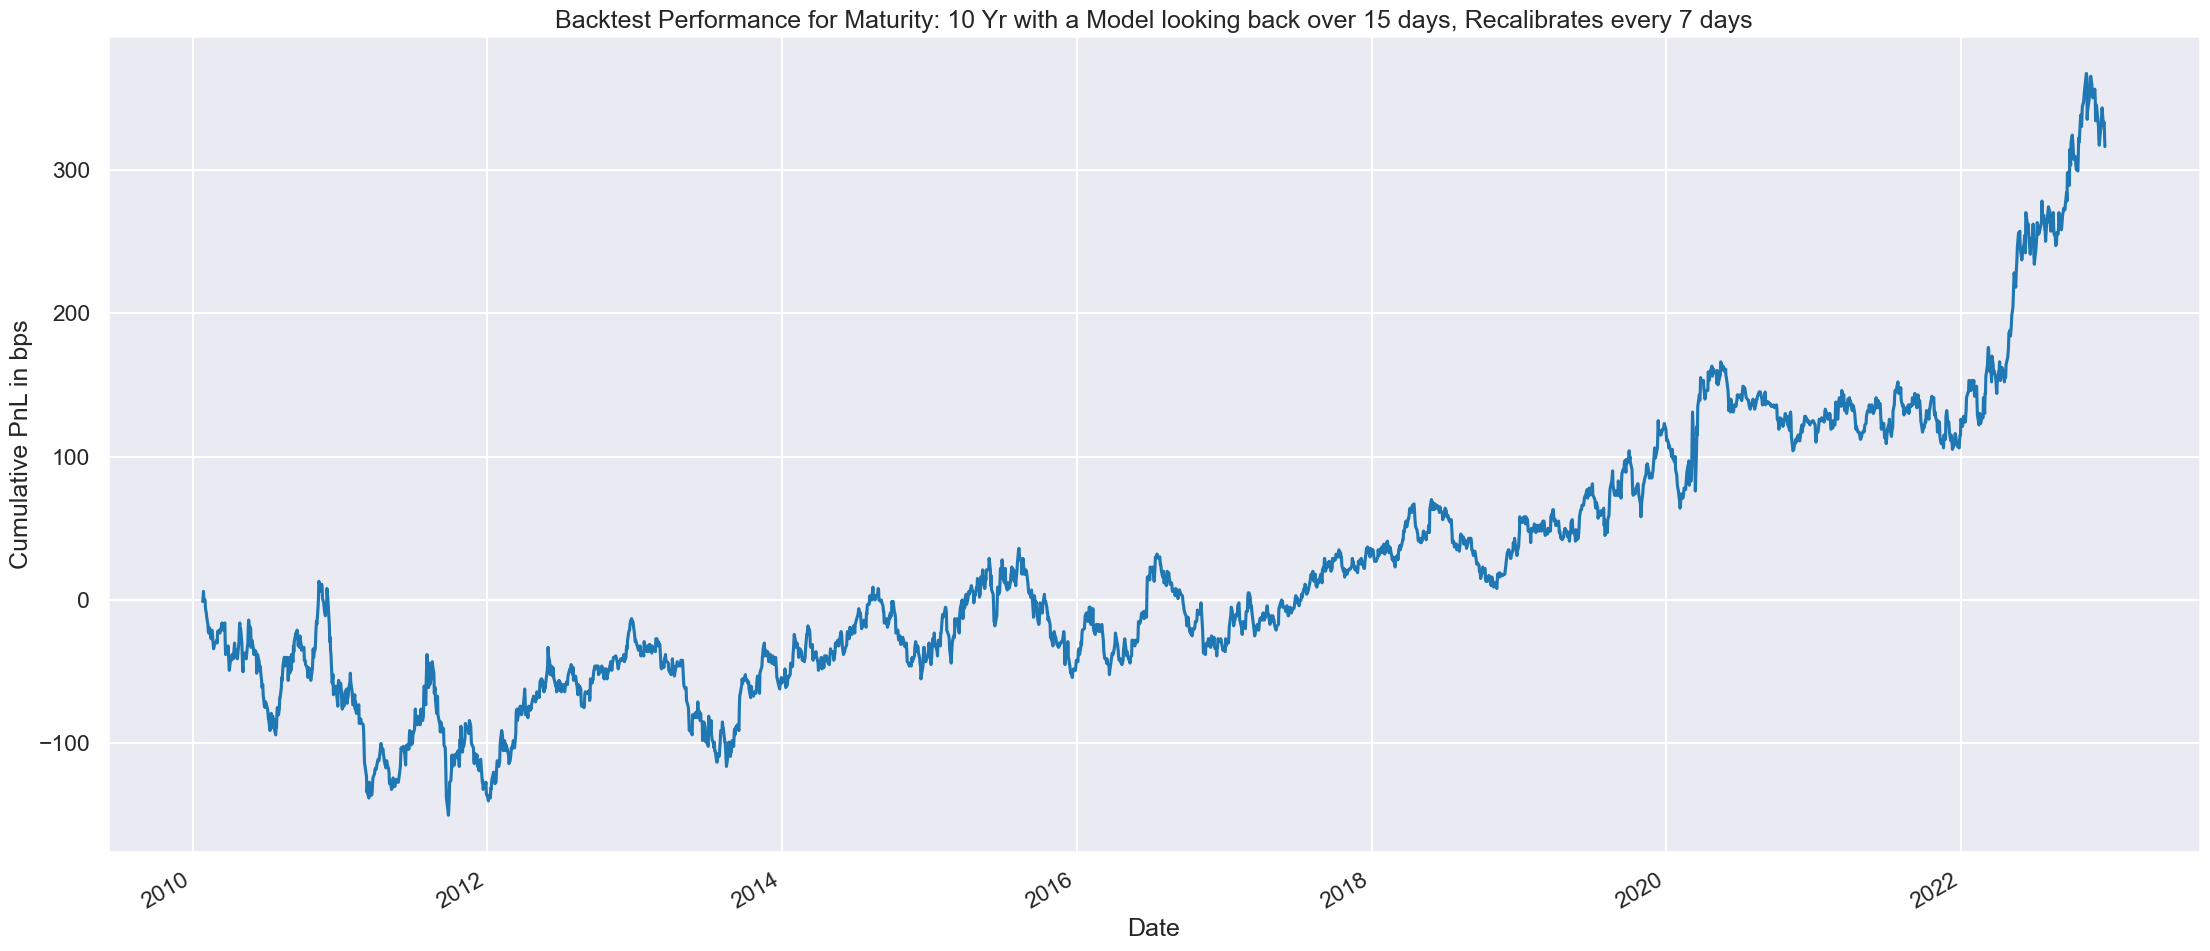

In [280]:
maturity = '10 Yr'
yields = historical_yields[maturity]
nss_parameters = historical_yields[['β0', 'β1', 'β2', 'β3', 'λ0', 'λ1']]

pnl = model_results(nss_parameters, yields, 15, 7, plot=True)

### Effect of Lookback and Recalibration Period on Cumulative PnL

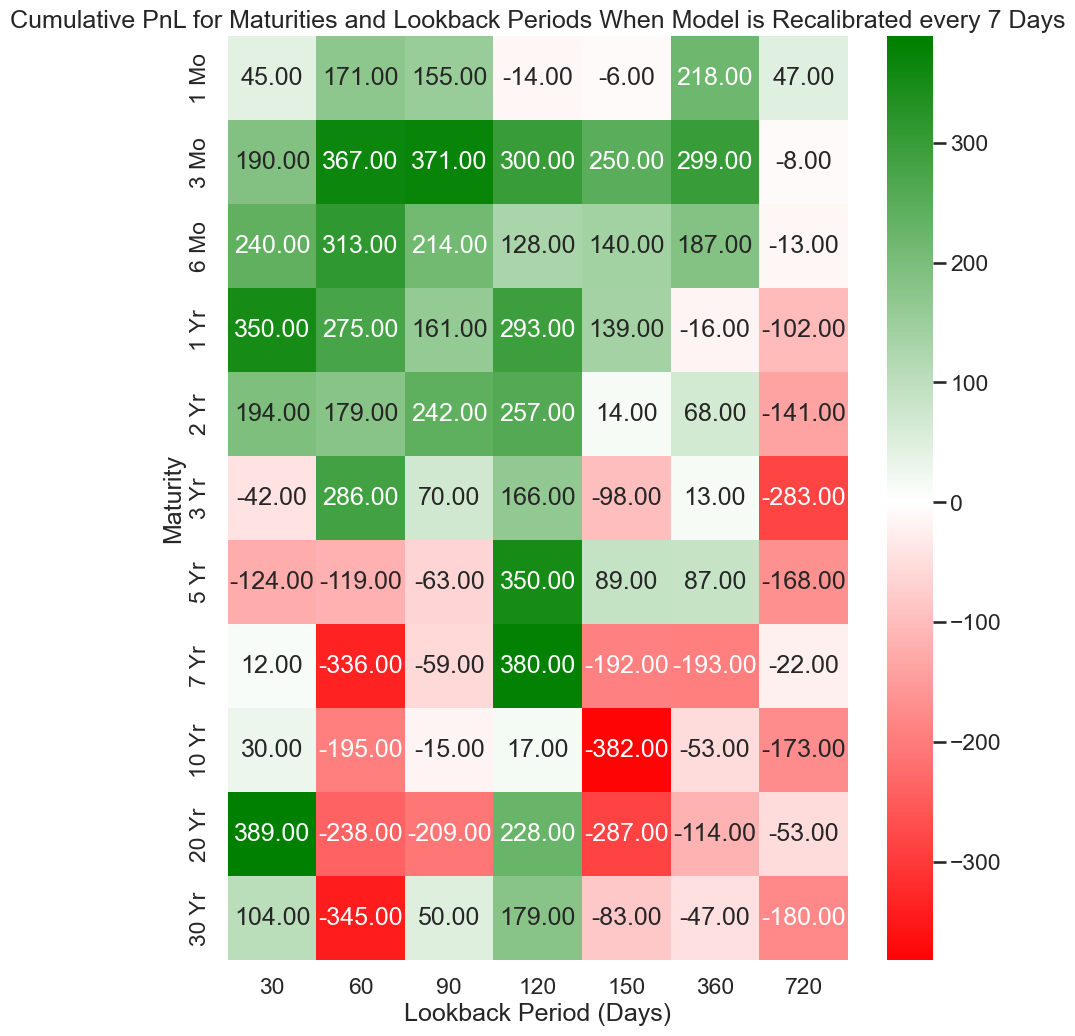

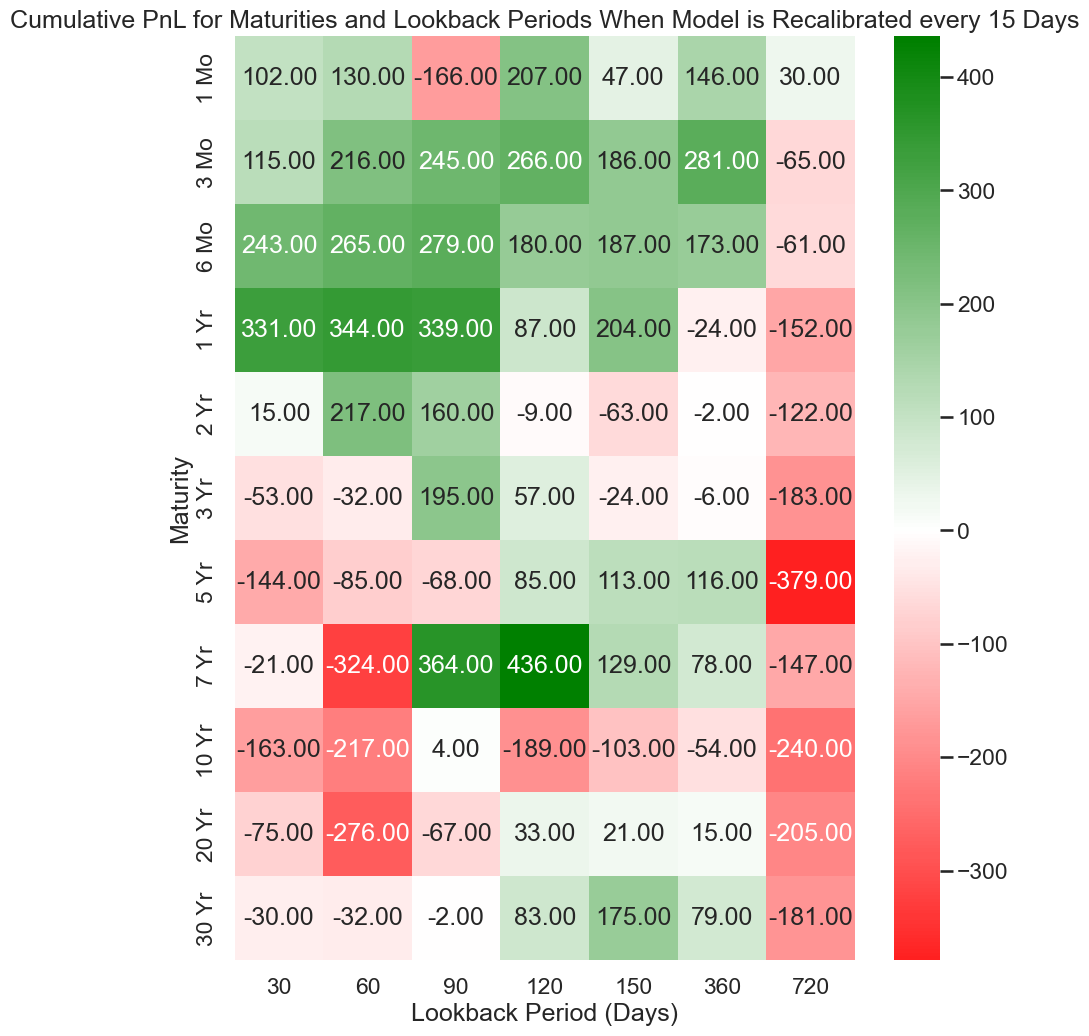

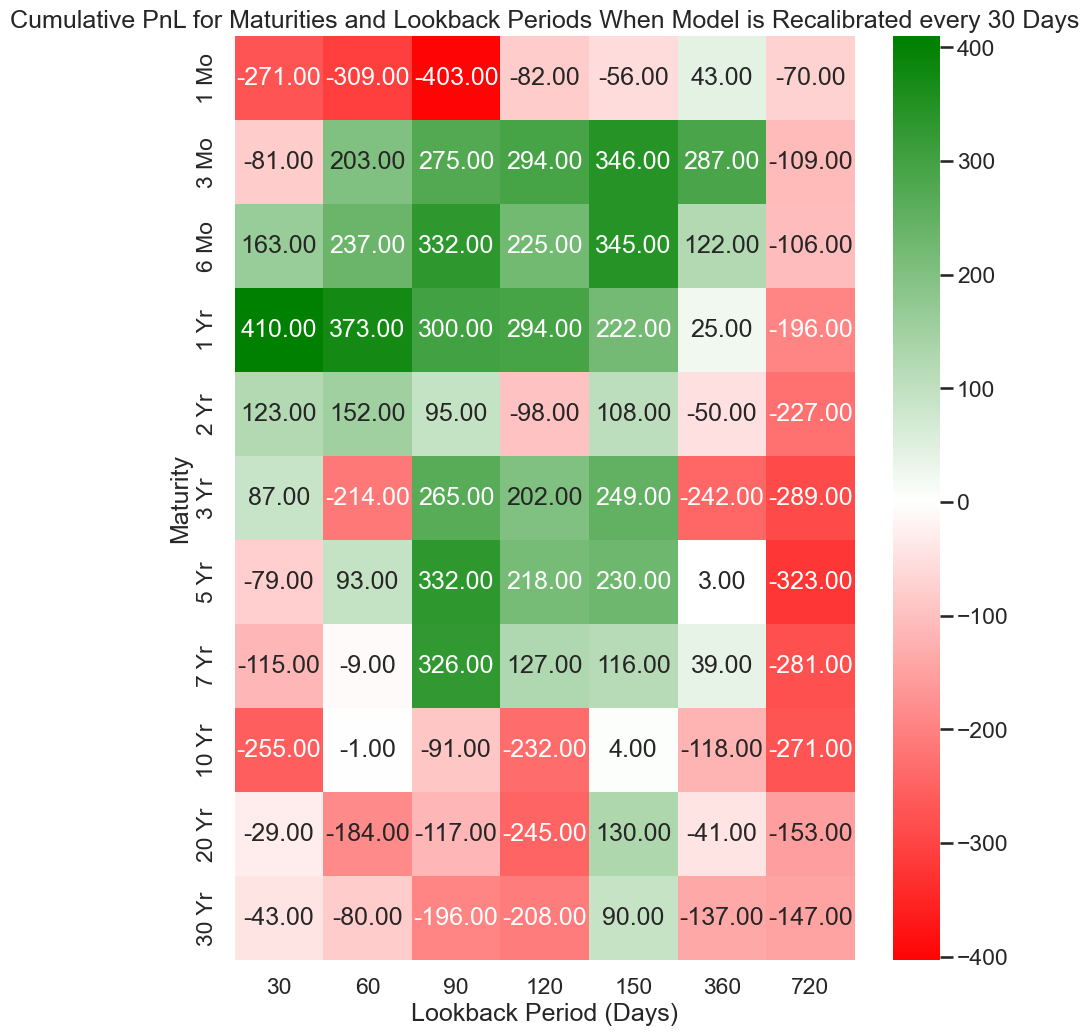

In [291]:
all_pnl = {}
for recalibration_period in [7,15,30]:
    # Define the combinations of maturity and lookback periods
    maturities = ['1 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr']
    lookbacks = [30, 60, 90, 120, 150, 360, 720]

    # Initialize a DataFrame to store the final cumulative PnL for each combination
    pnl_data = pd.DataFrame(index=maturities, columns=lookbacks)

    # Iterate over each combination, run the model, and store the results
    for maturity in maturities:
        yields = historical_yields[maturity]
        nss_parameters = historical_yields[['β0', 'β1', 'β2', 'β3', 'λ0', 'λ1']]
        for lookback in lookbacks:
            final_pnl = model_results(nss_parameters, yields, lookback, recalibration_period).cumsum().iloc[-1]
            pnl_data.loc[maturity, lookback] = final_pnl

    # Plot the results
    pnl_data = pnl_data.apply(pd.to_numeric)
    all_pnl[recalibration_period] = pnl_data

    # Define a custom colormap from red to green
    cmap = LinearSegmentedColormap.from_list(
        name='red_green', 
        colors=['red', 'white', 'green'],
        N=256  # Number of color segments
    )

    # Assuming pnl_data is already converted to numeric and contains the data to be plotted

    # Plotting the heatmap
    plt.figure(figsize=(10, 12))
    sns.heatmap(pnl_data, annot=True, cmap=cmap, fmt=".2f", center=0)
    plt.title(f'Cumulative PnL for Maturities and Lookback Periods When Model is Recalibrated every {recalibration_period} Days')
    plt.xlabel('Lookback Period (Days)')
    plt.ylabel('Maturity')
    plt.show()

